<div class="jumbotron text-left"><b>
This tutorial describes how to use the SMT toolbox, which is a python toolbox for building a surrogate model.</b></div>

Nathalie BARTOLI ONERA/DTIS/M2CI - May 2019

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper is available 
here https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub 

or as a preprint: http://mdolab.engin.umich.edu/content/python-surrogate-modeling-framework-derivatives

Cite us:

M.-A. Bouhlel, J. T. Hwang, N. Bartoli, R. Lafage, J. Morlier, J .R.R.A Martins (2019), A Python surrogate modeling framework with derivatives, Advances in Engineering Software, 102662


# 0. Construction of the DOE points

In [1]:
from __future__ import print_function, division
import numpy as np
from scipy import linalg
from smt.utils import compute_rms_error

from smt.problems import Sphere, NdimRobotArm, Rosenbrock
from smt.sampling_methods import LHS
from smt.surrogate_models import LS, QP, KPLS, KRG, KPLSK, GEKPLS
try:
    from smt.surrogate_models import IDW, RBF, RMTC, RMTB
    compiled_available = True
except:
    compiled_available = False

try:
    import matplotlib.pyplot as plt
    plot_status = True
except:
    plot_status = False

import scipy.interpolate

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

## Rosenbrock Function  in dimension N

$$
f(\mathbf{x}) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2 \quad \mbox{where} \quad \mathbf{x} = [x_1, \ldots, x_N] \in \mathbb{R}^N.
$$

$$x_i \in [-2,2]$$
    

## Training points and validation points using a LHS algorithm

Here we outline the studied function by plotting the surface representing the function. In addition, we plot also the training points used later to build the surrogate model as well as the validation points which will be used to evaluate the quality of the surrogate model. Both the training point and validation points are generated by a LHS DOE algorithm.

In [2]:
########### Initialization of the problem, construction of the training and validation points

ndim = 2
ndoe = 20 #int(10*ndim)
# Define the function
fun = Rosenbrock(ndim=ndim)

# Construction of the DOE
sampling = LHS(xlimits=fun.xlimits, criterion='m')
xt = sampling(ndoe)
# Compute the outputs
yt = fun(xt)

# Construction of the validation points
ntest = 200 #500
sampling = LHS(xlimits=fun.xlimits)
xtest = sampling(ntest)
ytest = fun(xtest)

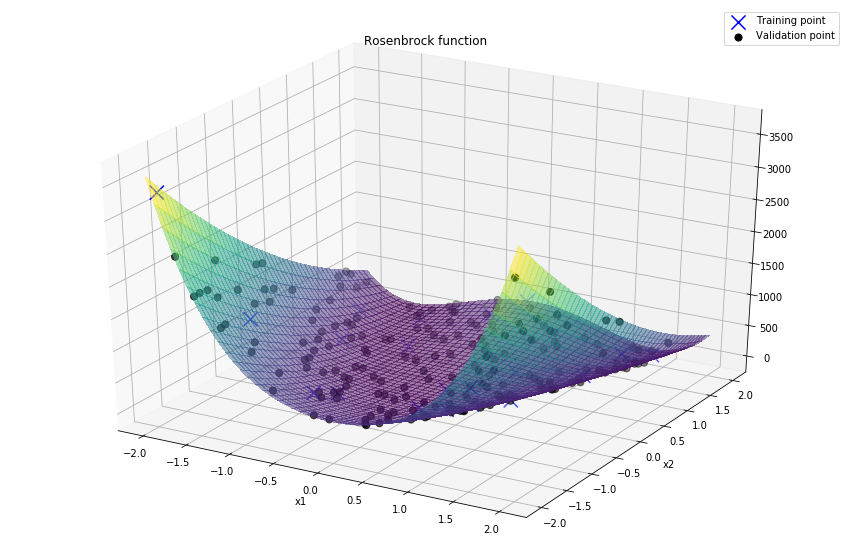

In [3]:
# To plot the Rosenbrock function
x = np.linspace(-2,2,50)
res = []
for x0 in x:
    for x1 in x:
        res.append(fun(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res, cmap=cm.viridis,
                       linewidth=0, antialiased=False,alpha=0.5)

ax.scatter(xt[:,0],xt[:,1],yt,zdir='z',marker = 'x',c='b',s=200,label='Training point')
ax.scatter(xtest[:,0],xtest[:,1],ytest,zdir='z',marker = '.',c='k',s=200,label='Validation point')

plt.title('Rosenbrock function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

Different models will be used and compared:

- Linear Model
- Quadratic Model
- Kriging Model
- KPLS Model (Useful for kriging in high dimension)
- IDW Model
- RBF Model
- RMTS Models: RMTB and RMTC (Useful for low dimensional problem)

Some metrics to assess some errors are proposed at the end.

# 1. Linear Model

___________________________________________________________________________
   
                                    LS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0000000
RBF,  err: 0.7219429022761861


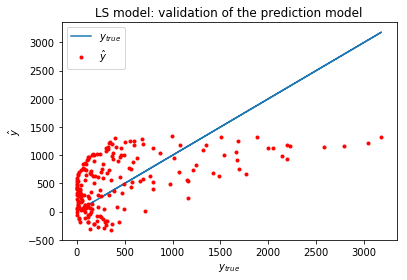

In [4]:
########### The LS model

# Initialization of the model
t = LS(print_prediction = False)

# Add the DOE
t.set_training_values(xt,yt[:,0])

# Train the model
t.train()

# Prediction of the validation points
y = t.predict_values(xtest)
print('RBF,  err: '+str(compute_rms_error(t,xtest,ytest)))

# Plot prediction/true values
if plot_status:

    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
       
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
        
    plt.legend(loc='upper left')
    plt.title('LS model: validation of the prediction model')

# 2. Quadratic Model

___________________________________________________________________________
   
                                    QP
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0311999
QP,  err: 0.5251452894942743


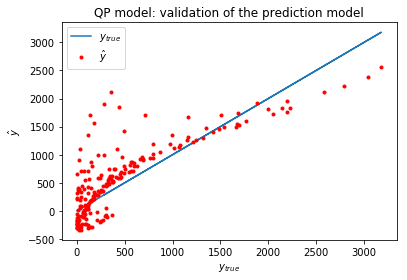

In [5]:
########### The QP model

t = QP(print_prediction = False)
t.set_training_values(xt,yt[:,0])

t.train()

# Prediction of the validation points
y = t.predict_values(xtest)
print('QP,  err: '+str(compute_rms_error(t,xtest,ytest)))

# Plot prediction/true values
if plot_status:

    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
       
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
        
    plt.legend(loc='upper left')
    plt.title('QP model: validation of the prediction model')


# 3. Kriging Model

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0156000
Kriging,  err: 0.0014593545294243387


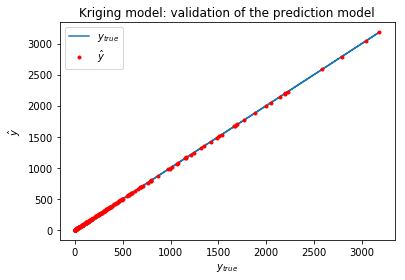

theta values [0.0306061  0.00026926]


In [6]:
########### The Kriging model

# The variable 'theta0' is a list of length ndim.
t = KRG(theta0=[1e-2]*ndim,print_prediction = False)
t.set_training_values(xt,yt[:,0])

t.train()

# Prediction of the validation points
y = t.predict_values(xtest)
print('Kriging,  err: '+ str(compute_rms_error(t,xtest,ytest)))
if plot_status:
    
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('Kriging model: validation of the prediction model')   

if plot_status:
    plt.show()

# Value of theta
print("theta values",  t.optimal_theta)

## Visualization 
Here we visualize the prediction using the Kriging surrogate.

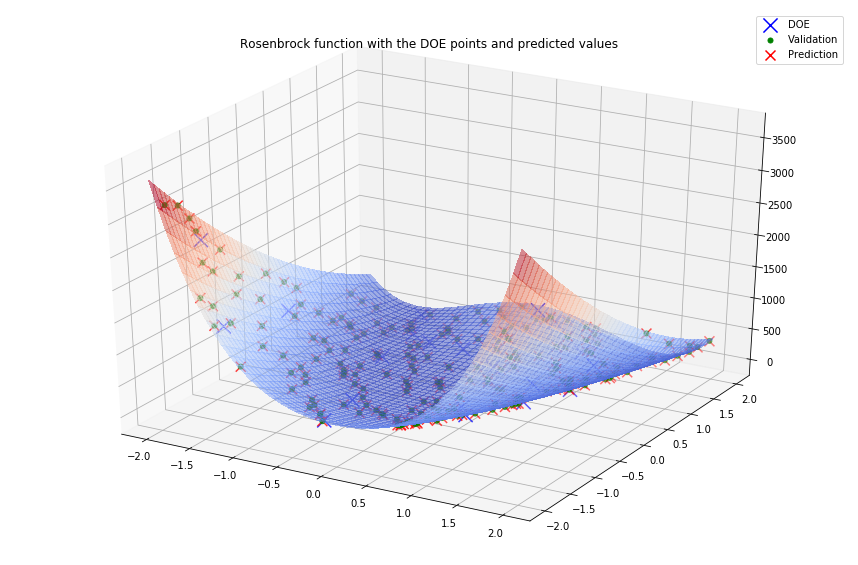

In [8]:
# Plot the surrogate model in 3D 
x = np.linspace(-2, 2, 50)
resSM = []
varSM = []
for x0 in x:
    for x1 in x:
        resSM.append(t.predict_values(np.array([[x0,x1]])))
        varSM.append(t.predict_variances(np.array([[x0,x1]])))
        
resSM = np.array(resSM)
resSM = resSM.reshape((50,50)).T
varSM = np.array(varSM)
varSM = varSM.reshape((50,50)).T                     
X,Y = np.meshgrid(x,x)


fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
ax.scatter(xt[:,0], xt[:,1], yt, zdir='z', marker='x', c='b', s=200, label='DOE')
surf = ax.plot_surface(X, Y, resSM, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
ax.scatter(xtest[:,0], xtest[:,1], ytest, zdir='z', marker='.', c='g', s=100, label='Validation')
ax.scatter(xtest[:,0], xtest[:,1], y, zdir='z', marker = 'x', c='r', s=100, label='Prediction')
plt.legend()
plt.title('Rosenbrock function with the DOE points and predicted values')

plt.show()

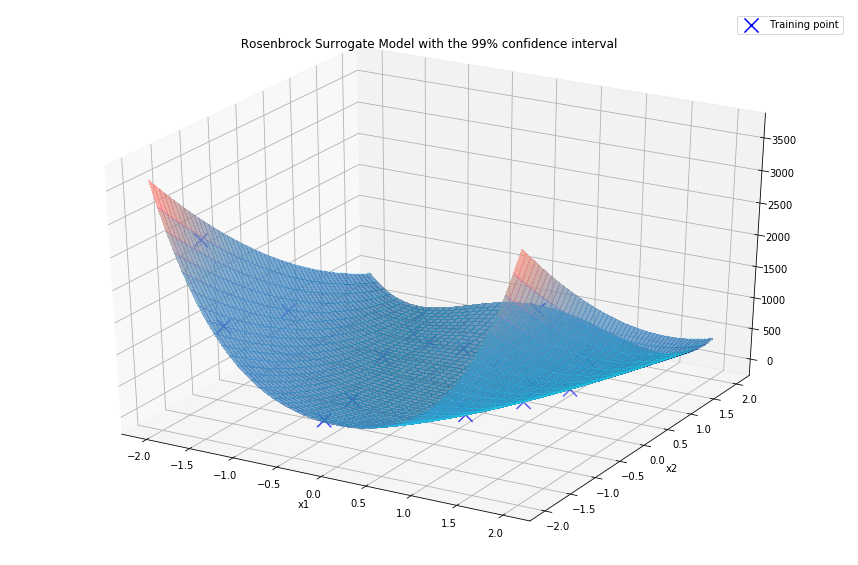

In [9]:
# Plot the surrogate with 99% confidence
fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, resSM, cmap=cm.viridis,
                       linewidth=0, antialiased=False,alpha=0.5)
surf = ax.plot_surface(X, Y, resSM+3*np.sqrt(varSM), color='r',  cmap=cm.cool,
                       linewidth=0, antialiased=False,alpha=0.2)
surf = ax.plot_surface(X, Y, resSM-3*np.sqrt(varSM), color='r',  cmap=cm.cool,
                       linewidth=0, antialiased=False,alpha=0.2)


ax.scatter(xt[:,0],xt[:,1],yt,zdir='z',marker = 'x',c='b',s=200,label='Training point')
#ax.scatter(xtest[:,0],xtest[:,1],ytest,zdir='z',marker = '.',c='k',s=200,label='Validation point')

plt.title(' Rosenbrock Surrogate Model with the 99% confidence interval ')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

No handles with labels found to put in legend.


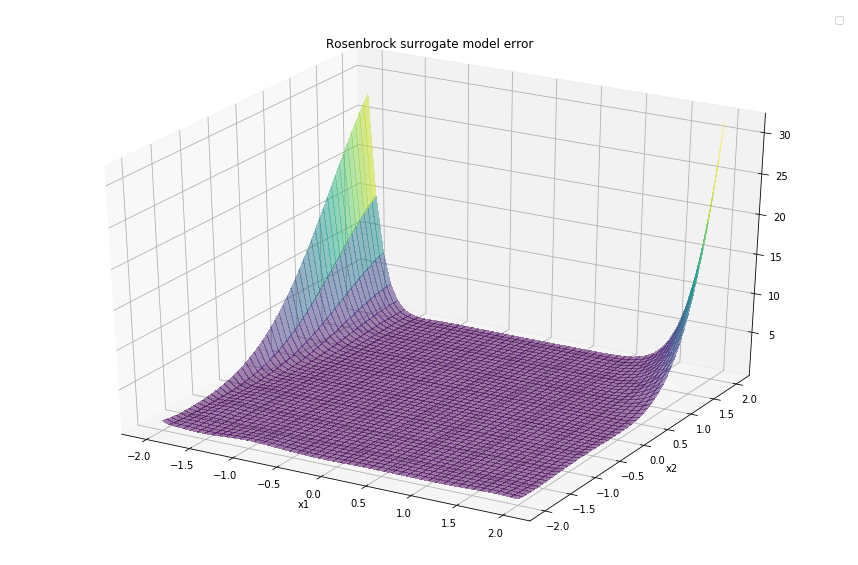

In [10]:
# Plot of the variance
fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, varSM, cmap=cm.viridis,
                       linewidth=0, antialiased=False, alpha=0.5)

plt.title('Rosenbrock surrogate model error')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

# 4. KPLSK Model
Here we implement the KLPSK model.

___________________________________________________________________________
   
                                   KPLSK
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0624001
KPLSK,  err: 0.0003165132445379041


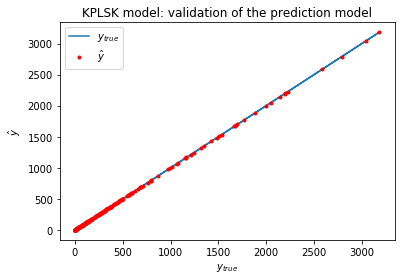

In [11]:
########### The KPLSK model

# 'n_comp' and 'theta0' must be an integer in [1,ndim[ and a list of length n_comp, respectively.

t = KPLSK(n_comp=2, theta0=[1e-2,1e-2], print_prediction=False)
t.set_training_values(xt, yt[:,0])

t.train()

# Prediction of the validation points
y = t.predict_values(xtest)
print('KPLSK,  err: '+str(compute_rms_error(t,xtest,ytest)))

#plot prediction/true values
if plot_status:
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('KPLSK model: validation of the prediction model')

if plot_status:
    plt.show()

# 5. IDW Model
Here we implement the IDW model.

___________________________________________________________________________
   
                                    IDW
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0000000
IDW,  err: 0.3059621932438578


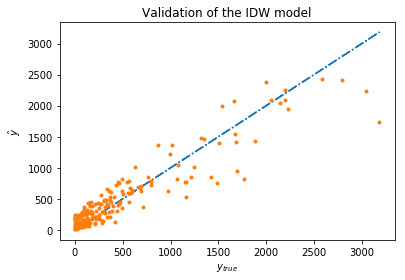

In [12]:
if compiled_available:
########### The IDW model

    t = IDW(print_prediction=False)
    t.set_training_values(xt, yt[:,0])

    t.train()

    # Prediction of the validation points
    y = t.predict_values(xtest)
    print('IDW,  err: '+str(compute_rms_error(t, xtest, ytest)))
    if plot_status:
        plt.figure()
        plt.plot(ytest,ytest,'-.')
        plt.plot(ytest,y,'.')
        plt.xlabel(r'$y_{true}$')
        plt.ylabel(r'$\hat{y}$')
        plt.title('Validation of the IDW model')
        plt.show()

# 6. RBF Model
Here we implement the RBF model.

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (21 x 21 mtx) ...
         Performing LU fact. (21 x 21 mtx) - done. Time (sec):  0.0000000
      Initializing linear solver - done. Time (sec):  0.0156002
      Solving linear system (col. 0) ...
         Back solving (21 x 21 mtx) ...
         Back solving (21 x 21 mtx) - done. Time (sec):  0.0000000
      Solving linear system (col. 0) - done. Time (sec):  0.0000000
   Training - done. Time (sec):  0.0156002
RBF,  err: 0.28117925935743215


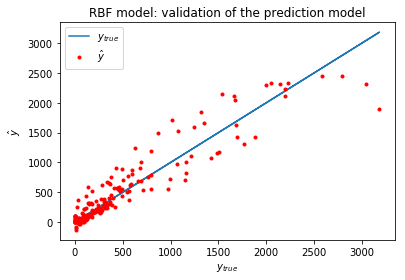

In [13]:
if compiled_available:
     ########### The RBF model

    t = RBF(print_prediction = False,poly_degree = 0)
    t.set_training_values(xt,yt[:,0])

    t.train()

    # Prediction of the validation points
    y = t.predict_values(xtest)
    print('RBF,  err: '+str(compute_rms_error(t,xtest,ytest)))
    # Plot prediction/true values
    if plot_status:
        fig = plt.figure()
        plt.plot(ytest, ytest, '-', label='$y_{true}$')
        plt.plot(ytest, y, 'r.', label='$\hat{y}$')
       
        plt.xlabel('$y_{true}$')
        plt.ylabel('$\hat{y}$')
        
        plt.legend(loc='upper left')
        plt.title('RBF model: validation of the prediction model')

# 7. RMTS Models

The RMTB and RMTC models are suitable for low-dimensional problems.

## 7.1 RMTB Model

___________________________________________________________________________
   
                                   RMTB
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Pre-computing matrices ...
         Computing dof2coeff ...
         Computing dof2coeff - done. Time (sec):  0.0000000
         Initializing Hessian ...
         Initializing Hessian - done. Time (sec):  0.0000000
         Computing energy terms ...
         Computing energy terms - done. Time (sec):  0.0000000
         Computing approximation terms ...
         Computing approximation terms - done. Time (sec):  0.0000000
      Pre-computing matrices - done. Time (sec):  0.0000000
      Solving for degrees of freedom ...
         Solving initial startup problem (n=225) ...
            Solving for output 0 ...
       

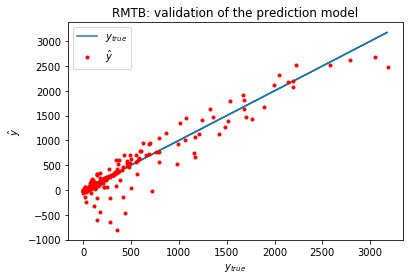

In [14]:
if compiled_available:
########### The RMTB model

    t = RMTB(xlimits=fun.xlimits, min_energy=True, nonlinear_maxiter=20, print_prediction=False)
    t.set_training_values(xt, yt[:,0])
    # Add the gradient information
#    for i in range(ndim):
#        t.set_training_derivatives(xt,yt[:, 1+i].reshape((yt.shape[0],1)),i)
    t.train()

    # Prediction of the validation points
    y = t.predict_values(xtest)
    print('RMTB,  err: '+str(compute_rms_error(t, xtest, ytest)))
    #plot prediction/true values
    if plot_status:
        fig = plt.figure()
        plt.plot(ytest, ytest, '-', label='$y_{true}$')
        plt.plot(ytest, y, 'r.', label='$\hat{y}$')
       
        plt.xlabel('$y_{true}$')
        plt.ylabel('$\hat{y}$')
        
        plt.legend(loc='upper left')
        plt.title('RMTB: validation of the prediction model')     
    
    if plot_status:
        plt.show()

## 7.2 RMTC Model

___________________________________________________________________________
   
                                   RMTC
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Pre-computing matrices ...
         Computing dof2coeff ...
         Computing dof2coeff - done. Time (sec):  0.0156002
         Initializing Hessian ...
         Initializing Hessian - done. Time (sec):  0.0000000
         Computing energy terms ...
         Computing energy terms - done. Time (sec):  0.0000000
         Computing approximation terms ...
         Computing approximation terms - done. Time (sec):  0.0000000
      Pre-computing matrices - done. Time (sec):  0.0156002
      Solving for degrees of freedom ...
         Solving initial startup problem (n=100) ...
            Solving for output 0 ...
       

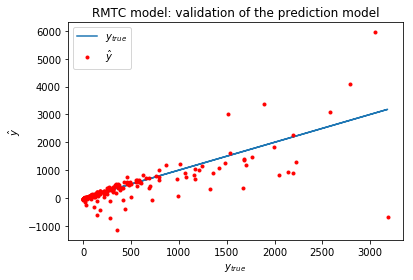

In [16]:
if compiled_available:
########### The RMTC model

    t = RMTC(xlimits=fun.xlimits, min_energy=True, nonlinear_maxiter=20, print_prediction=False)
    t.set_training_values(xt, yt[:,0])
#    # Add the gradient information
#    for i in range(ndim):
#        t.set_training_derivatives(xt,yt[:, 1+i].reshape((yt.shape[0],1)),i)

    t.train()

    # Prediction of the validation points
    y = t.predict_values(xtest)
    print('RMTC,  err: '+str(compute_rms_error(t, xtest, ytest)))
    #plot prediction/true values
    if plot_status:
        fig = plt.figure()
        plt.plot(ytest, ytest, '-', label='$y_{true}$')
        plt.plot(ytest, y, 'r.', label='$\hat{y}$')
       
        plt.xlabel('$y_{true}$')
        plt.ylabel('$\hat{y}$')
        
        plt.legend(loc='upper left')
        plt.title('RMTC model: validation of the prediction model')
    
    if plot_status:
        plt.show()

# 8. Computation of error metrics

We compute several types of error,  
- the  mean square error
$$
\text{MSE} = \sum\limits_{i=1}^{n_\text{test}}\left(y\left(\textbf{x}_{\text{test},i}\right)-\hat{y}\left(\textbf{x}_{\text{test},i}\right)\right)^2
$$
- the relative error (RE in %) 
$$
\text{RE} = \frac{\sqrt{\sum\limits_{i=1}^{n_\text{test}}\left(y\left(\textbf{x}_{\text{test},i}\right)-\hat{y}\left(\textbf{x}_{\text{test},i}\right)\right)^2}}{\sqrt{\sum\limits_{i=1}^{n_{\text{test}}}\left(y\left(\textbf{x}_{\text{test},i}\right)\right)^2}}100,
$$ 
-  the Coefficient of variation or Coefficient of correlation (R2)
$$
\text{R2} = 1- \frac{{\sum\limits_{i=1}^{n_\text{test}}\left(y\left(\textbf{x}_{\text{test},i}\right)-\hat{y}\left(\textbf{x}_{\text{test},i}\right)\right)^2}}{\sqrt{\sum\limits_{i=1}^{n_{\text{test}}}\left(y\left(\textbf{x}_{\text{test},i}  \right)- \bar y \right)^2}},
$$ 
where  ${\displaystyle {\bar {y}}}$  is the mean of the observed data:
$${\bar {y}}=\frac {1}{n_{\text{test}}}\sum _{i=1}^{n_{\text{test}}}\hat{y}\left(\textbf{x}_{\text{test},i}\right)$$
An R2 of 1 indicates that the regression line perfectly fits the data.



More metrics computed in scikit-learn are given in http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics


In [17]:
from sklearn.metrics import mean_squared_error, r2_score


# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(ytest, y))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(ytest, y))

Mean squared error: 239308.34
Variance score: 0.38


# 9. Use of derivatives

Generate the data for the training and the test set

In [18]:
#Computation of the gradient for the DOE points
# Compute the gradient
for i in range(ndim):
    yd = fun(xt,kx=i)
    yt = np.concatenate((yt,yd),axis=1)

ydtest = np.zeros((ntest,ndim))
for i in range(ndim):
    ydtest[:,i] = fun(xtest,kx=i).T

# 9.1 GEKPLS model using 2 PLS components and 1 approximating point

Training phase

In [19]:
########### The GEKPLS model using 1 approximating point and 2 components 

# 'n_comp' must be an integer in [1,ndim[,  'theta0' a list of n_comp values

t = GEKPLS(n_comp=2, theta0=[1e-2,1e-2], xlimits=fun.xlimits,delta_x=1e-2,extra_points= 1,print_prediction = False)
t.set_training_values(xt,yt[:,0])
# Add the gradient information
for i in range(ndim):
    t.set_training_derivatives(xt,yt[:, 1+i].reshape((yt.shape[0],1)),i)

t.train()

___________________________________________________________________________
   
                                  GEKPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0779998


d:\rlafage\miniconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:291: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
d:\rlafage\miniconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:291: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
d:\rlafage\miniconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:291: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
d:\rlafage\miniconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:291: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
d:\rlafage\miniconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:291: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
d:\rlafage\miniconda3\lib\site-packages\sklearn\cross_decomp

Prediction phase for the function 

GEKPLS1,  err: 0.005933677910726076


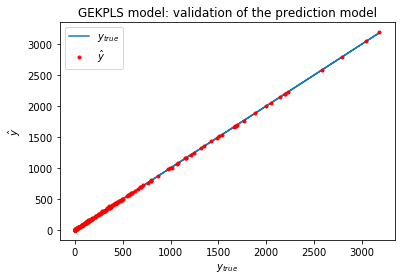

In [20]:
# Prediction of the validation points
y = t.predict_values(xtest)
print('GEKPLS1,  err: '+str(compute_rms_error(t,xtest,ytest)))
if plot_status:
       
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('GEKPLS model: validation of the prediction model')
 

Prediction phase for the derivatives

GEKPLS1, err of the 1-th derivative: 0.008904738980589752


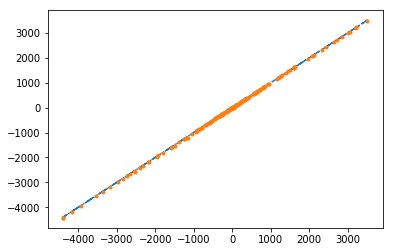

GEKPLS1, err of the 2-th derivative: 0.017206584209657365


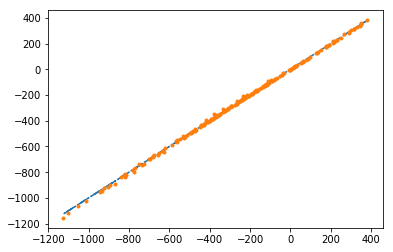

In [21]:

# Prediction of the derivatives with regards to each direction space
yd_prediction = np.zeros((ntest,ndim))
for i in range(ndim):
    yd_prediction[:,i] = t.predict_derivatives(xtest,kx=i).T
    print('GEKPLS1, err of the '+str(i+1)+'-th derivative: '+ str(compute_rms_error(t,xtest,ydtest[:,i],kx=i)))

    if plot_status:
        
        plt.plot(ydtest[:,i],ydtest[:,i],'-.')
        plt.plot(ydtest[:,i],yd_prediction[:,i],'.')

    if plot_status:
        plt.show()

# 9.2 GEKPLS model using 1 PLS component and 1 approximating point

Training phase

In [22]:

# 'n_comp' must be an integer in [1,ndim[,  'theta0' a list of n_comp values


t = GEKPLS(n_comp=1, theta0=[1e-2], xlimits=fun.xlimits,delta_x=1e-2,extra_points= 1,print_prediction = False)
t.set_training_values(xt,yt[:,0])
# Add the gradient information
for i in range(ndim):
    t.set_training_derivatives(xt,yt[:, 1+i].reshape((yt.shape[0],1)),i)

t.train()


___________________________________________________________________________
   
                                  GEKPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0467999


GEKPLS1,  err: 0.005933677910726076


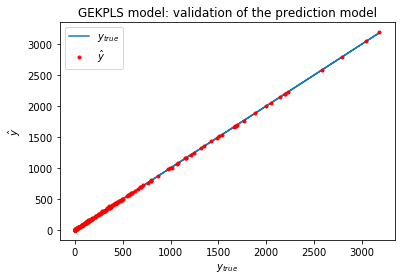

In [23]:
# Prediction of the validation points
y = t.predict_values(xtest)
print('GEKPLS1,  err: '+str(compute_rms_error(t,xtest,ytest)))
if plot_status:
       
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('GEKPLS model: validation of the prediction model')
 


Prediction phase for the derivatives

GEKPLS1, err of the 1-th derivative: 0.008904738980589752


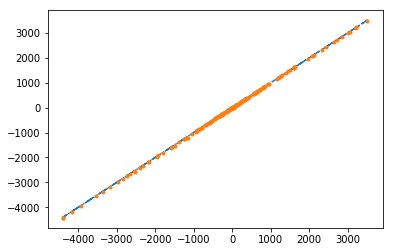

GEKPLS1, err of the 2-th derivative: 0.017206584209657365


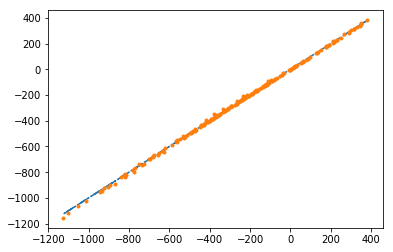

In [24]:

# Prediction of the derivatives with regards to each direction space
yd_prediction = np.zeros((ntest,ndim))
for i in range(ndim):
    yd_prediction[:,i] = t.predict_derivatives(xtest,kx=i).T
    print('GEKPLS1, err of the '+str(i+1)+'-th derivative: '+ str(compute_rms_error(t,xtest,ydtest[:,i],kx=i)))

    if plot_status:
        
        plt.plot(ydtest[:,i],ydtest[:,i],'-.')
        plt.plot(ydtest[:,i],yd_prediction[:,i],'.')

    if plot_status:
        plt.show()
        

# 9.3 GEKPLS model using 1 PLS component and 2 approximating points

Training phase

In [25]:
# 'n_comp' must be an integer in [1,ndim[,  'theta0' a list of n_comp values


t = GEKPLS(n_comp=1, theta0=[1e-2], xlimits=fun.xlimits,delta_x=1e-2,extra_points= 2,print_prediction = False)
t.set_training_values(xt,yt[:,0])
# Add the gradient information
for i in range(ndim):
    t.set_training_derivatives(xt,yt[:, 1+i].reshape((yt.shape[0],1)),i)

t.train()


___________________________________________________________________________
   
                                  GEKPLS
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 20
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0624001


Prediction for the function 

GEKPLS1,  err: 0.00366119928020505


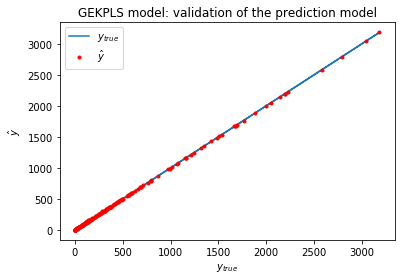

In [26]:
# Prediction of the validation points
y = t.predict_values(xtest)
print('GEKPLS1,  err: '+str(compute_rms_error(t,xtest,ytest)))
if plot_status:
       
    fig = plt.figure()
    plt.plot(ytest, ytest, '-', label='$y_{true}$')
    plt.plot(ytest, y, 'r.', label='$\hat{y}$')
   
    plt.xlabel('$y_{true}$')
    plt.ylabel('$\hat{y}$')
    
    plt.legend(loc='upper left')
    plt.title('GEKPLS model: validation of the prediction model')
 

Prediction for the derivatives

GEKPLS1, err of the 1-th derivative: 0.004755110100322462


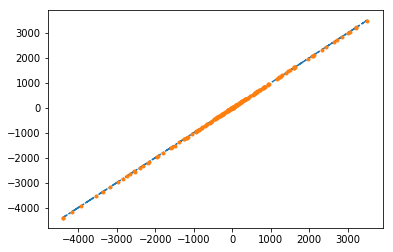

GEKPLS1, err of the 2-th derivative: 0.010437316270383596


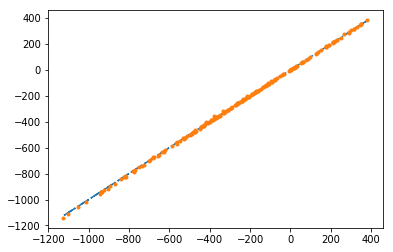

In [27]:

# Prediction of the derivatives with regards to each direction space
yd_prediction = np.zeros((ntest,ndim))
for i in range(ndim):
    yd_prediction[:,i] = t.predict_derivatives(xtest,kx=i).T
    print('GEKPLS1, err of the '+str(i+1)+'-th derivative: '+ str(compute_rms_error(t,xtest,ydtest[:,i],kx=i)))

    if plot_status:
        
        plt.plot(ydtest[:,i],ydtest[:,i],'-.')
        plt.plot(ydtest[:,i],yd_prediction[:,i],'.')

    if plot_status:
        plt.show()